In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [3]:
import numpy as np
from PIL import Image

def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(directory, filename))
            img=img.resize((256,256))
            images.append(img)
    return images

In [4]:
images=load_images_from_dir('/kaggle/input/human-faces/Humans')

In [10]:
image_arrays = [np.array(image) for image in images]



In [13]:
filtered_images = []
for image in image_arrays:
    if image.shape == (256, 256, 3) and len(filtered_images)<2000:
        filtered_images.append(image)

In [14]:
images_array = np.array(filtered_images)
images_array_norm=images_array/255

In [24]:
images_array.shape[0]

2000

In [25]:
x_train=images_array_norm[:1600]
x_test=images_array_norm[1600:]

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import itertools

In [16]:
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return noisy_image

In [17]:
def add_salt_and_pepper_noise(image, noise_level=0.05):
    noisy_image = np.copy(image)
    salt_and_pepper = np.random.rand(*image.shape)
    noisy_image[salt_and_pepper < noise_level / 2] = 0
    noisy_image[salt_and_pepper > 1 - noise_level / 2] = 1
    return noisy_image

In [18]:
def add_speckle_noise(image, std=0.1):
    noise = np.random.normal(0, std, image.shape)
    noisy_image = image + image * noise
    return noisy_image

In [19]:
def add_gaussian_noise_to_dataset(dataset, mean=0, std=0.1):
    noisy_dataset = np.zeros_like(dataset)
    for i in range(len(dataset)):
        noisy_dataset[i] = add_gaussian_noise(dataset[i], mean, std)
    return noisy_dataset

def add_salt_and_pepper_noise_to_dataset(dataset, noise_level=0.05):
    noisy_dataset = np.zeros_like(dataset)
    for i in range(len(dataset)):
        noisy_dataset[i] = add_salt_and_pepper_noise(dataset[i], noise_level)
    return noisy_dataset

def add_speckle_noise_to_dataset(dataset, std=0.1):
    noisy_dataset = np.zeros_like(dataset)
    for i in range(len(dataset)):
        noisy_dataset[i] = add_speckle_noise(dataset[i], std)
    return noisy_dataset

In [26]:
gn = add_gaussian_noise_to_dataset(dataset=x_train, std=0.05)  # Lower std value for Gaussian noise
x_train_noise = add_salt_and_pepper_noise_to_dataset(dataset=gn, noise_level=0.01)  # Lower noise_level for salt and pepper noise

In [27]:
gn = add_gaussian_noise_to_dataset(dataset=x_test, std=0.05)  # Lower std value for Gaussian noise
x_test_noise = add_salt_and_pepper_noise_to_dataset(dataset=gn, noise_level=0.01)  

In [28]:
x_train_noise = np.clip(x_train_noise, 0., 1.)
x_test_noise = np.clip(x_test_noise, 0., 1.)

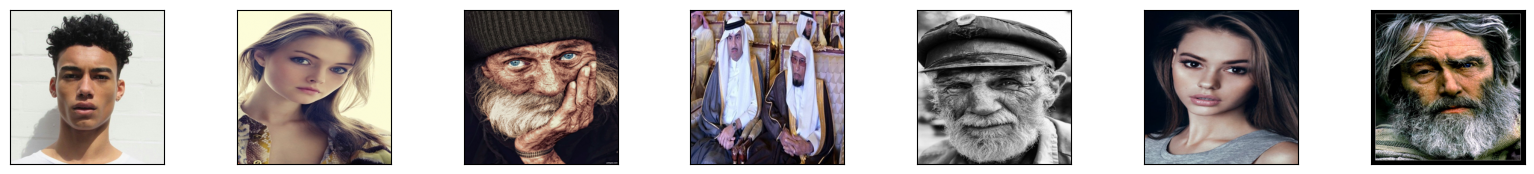

In [33]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(256, 256, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

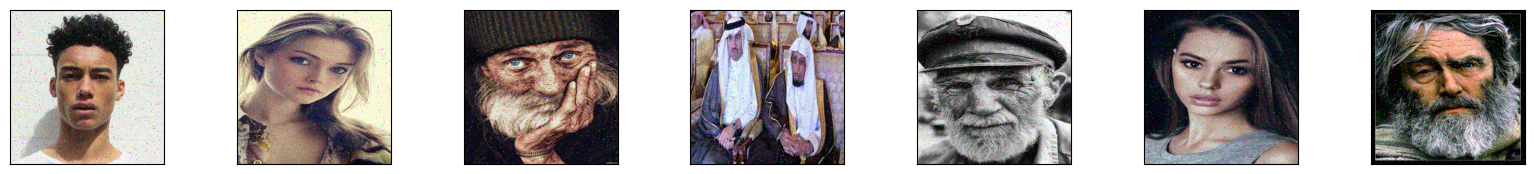

In [31]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noise[i].reshape(256, 256, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [35]:
import tensorflow as tf

In [46]:
model=tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256,256,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    #tf.keras.layers.Add(),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer
])

model.compile(optimizer='adam', loss='mse')  # You can experiment with other loss functions

In [52]:
model.fit(x_train_noise, x_train,
               epochs=50,
               batch_size=64,
               shuffle=True,
               validation_data=(x_test_noise, x_test))

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/50
16/25 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - loss: 0.0013

KeyboardInterrupt: 

In [49]:
loss = model.evaluate(x_test_noise, x_test)
print("Test Loss: ", loss)
predicted_imgs = model.predict(x_test_noise)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0014
Test Loss:  0.0013905849773436785
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [50]:
predicted_imgs.shape

(400, 256, 256, 3)

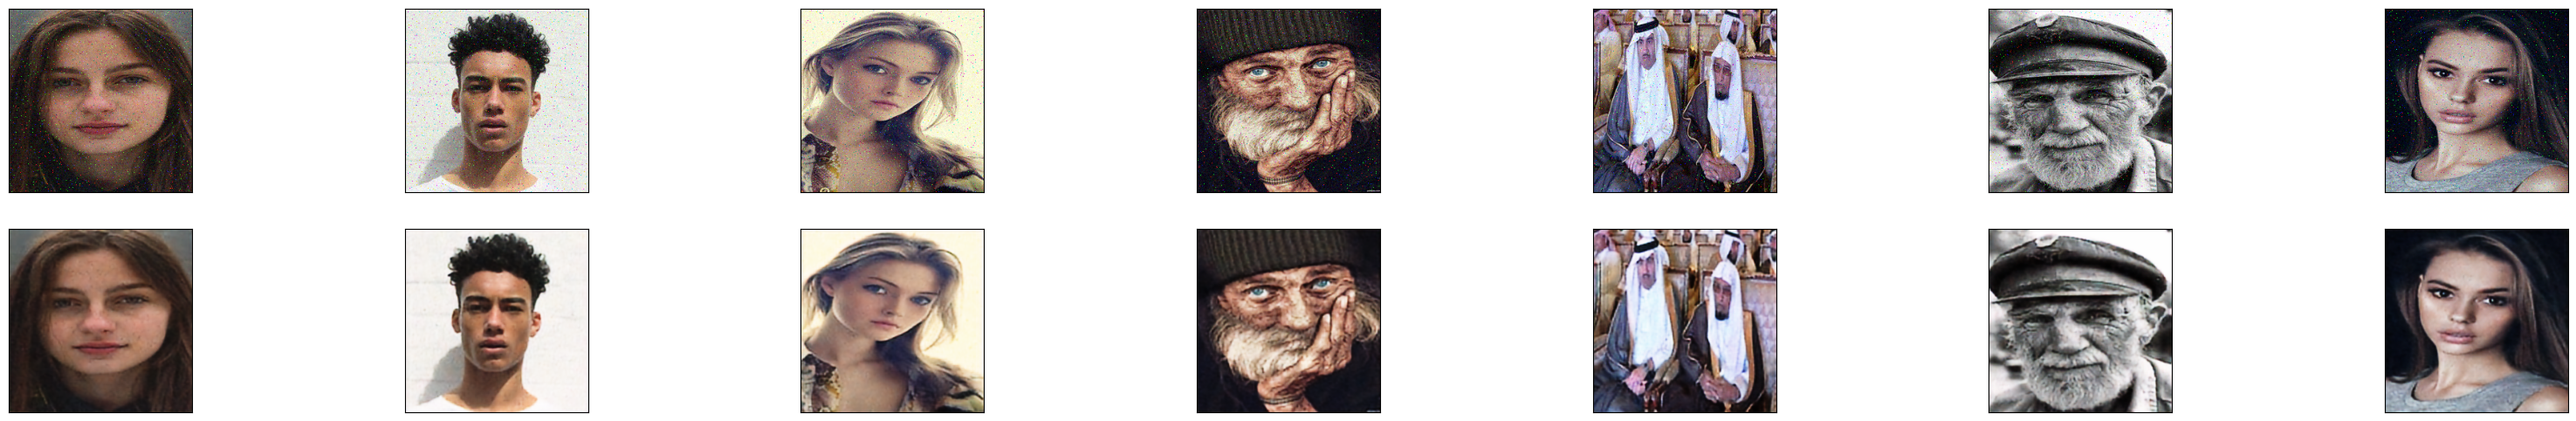

In [53]:
n = 7
plt.figure(figsize=(40, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noise[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(256, 256, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()